## Vargas Bravo Paola
# Práctica 06

In [1]:
import  PIL
from PIL import Image,ImageFilter
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
from skimage.util import random_noise
import cv2
from collections import Counter
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import matplotlib.cm as cm
from skimage.color import rgb2gray  

In [2]:
flowers_img = Image.open("flowers2.bmp")

In [3]:
def show_image(image, title, save=False, name="res.png", gray=False):
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off') 
    plt.show()

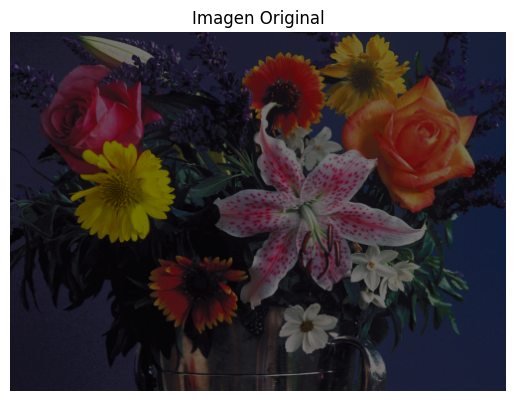

In [4]:
show_image(flowers_img, "Imagen Original")

In [5]:
def saturation(array,r,g,b):
    for i in range(len(array)):
        for j in range(len(array[0])):
            min_rgb = np.min([r[i][j], g[i][j], b[i][j]])
            
            array[i][j] = 1 - ( (3* min_rgb) / (r[i][j] + g[i][j] + b[i][j] + 0.0001))
    return array

In [6]:
def intensity(array,r,g,b):
    for i in range(len(array)):
        for j in range(len(array[0])):
            array[i][j] = (r[i][j] + g[i][j] + b[i][j]) / 3
    return array

In [7]:
def tone (array,r,g,b):
     for i in range(len(array)):
        for j in range(len(array[0])):
            frac = (0.5 * ((r[i][j] - g[i][j]) + (r[i][j] - b[i][j]))) / ((math.sqrt(((r[i][j] - g[i][j]) ** 2 + ((r[i][j] - b[i][j]) * (g[i][j] - b[i][j]))))) + 0.00001)
            theta = math.acos(frac)
            theta = math.degrees(theta)          
            if b[i][j] <= g[i][j]:
                array[i][j] = theta
            else:
                array[i][j] = 360 - theta
     array /= 360
     return array

In [8]:
def rgb_to_hsi(image):
    img_array = np.float32(image)
    img_array /= 255 # Normalizamos
    r = img_array[:,:,0]
    g = img_array[:,:,1]
    b = img_array[:,:,2]
    
    H = np.zeros(r.shape, dtype=np.float32)
    H = tone (H,r,g,b)
    
    S = np.zeros(g.shape, dtype=np.float32)
    S = saturation(S,r,g,b)
    
    I = np.zeros(b.shape, dtype=np.float32)
    I = intensity(I,r,g,b)
    hsi_img = cv2.merge((I, S, H)) 
            
    return hsi_img

In [9]:
hsi_flowers = rgb_to_hsi(flowers_img)

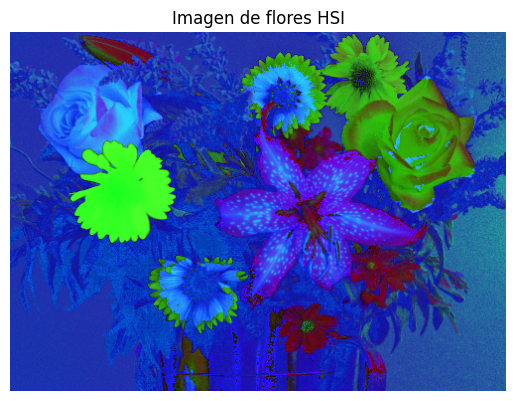

In [10]:
show_image(hsi_flowers, "Imagen de flores HSI")

In [11]:
def calculate_array_histogram(array):
    # Calcula el histograma del array
    histogram = np.bincount(array.flatten(), minlength=256)
    return histogram

In [12]:
def calculate_normalized_cumulative_distribution(histogram):
    # Calcula la distribución acumulativa normalizada
    cumulative_distribution = np.cumsum(histogram) / np.sum(histogram)
    return cumulative_distribution

In [13]:
def perform_intensity_equalization(array):
    histogram = calculate_array_histogram(array)
    cumulative_distribution = calculate_normalized_cumulative_distribution(histogram)
    equalized_array = np.floor(255 * cumulative_distribution[array]).astype(np.uint8)
    return equalized_array.reshape(array.shape)

In [14]:
hsi_array = np.float32(hsi_flowers)
intensity = perform_intensity_equalization(np.uint8(hsi_array[:, :, 0] * 255)) / 255.0
hsi_array[:,:,0] = intensity

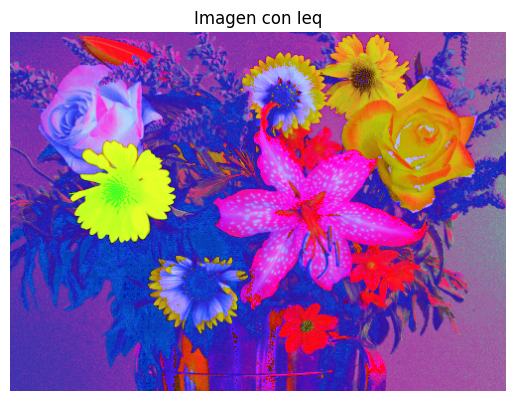

In [15]:
show_image(hsi_array, "Imagen con Ieq")

In [16]:
def hsi_to_rgb(hsi_array):
    intensity = perform_intensity_equalization(np.uint8(hsi_array[:, :, 0] * 255)) / 255.0
    saturation = hsi_array[:, :, 1]
    hue = hsi_array[:, :, 2] * 360

    red, green, blue = np.ones(saturation.shape), np.ones(saturation.shape), np.ones(saturation.shape)

    for i in range(len(hsi_array)):
        for j in range(len(hsi_array[0])):
            H = hue[i][j]

            if 0 <= H < 120:
                rH = math.radians(H)
                blue[i][j] = intensity[i][j] * (1 - saturation[i][j])
                red[i][j] = intensity[i][j] * (1 + ((saturation[i][j] * math.cos(rH)) / math.cos(math.radians(60) - rH)))
                green[i][j] = (3 * intensity[i][j]) - (red[i][j] + blue[i][j])

            elif 120 <= H < 240:
                H -= 120
                rH = math.radians(H)
                red[i][j] = intensity[i][j] * (1 - saturation[i][j])
                green[i][j] = intensity[i][j] * (1 + ((saturation[i][j] * math.cos(rH)) / math.cos(math.radians(60) - rH)))
                blue[i][j] = (3 * intensity[i][j]) - (red[i][j] + green[i][j])

            else:
                H -= 240
                rH = math.radians(H)
                green[i][j] = intensity[i][j] * (1 - saturation[i][j])
                blue[i][j] = intensity[i][j] * (1 + ((saturation[i][j] * math.cos(rH)) / math.cos(math.radians(60) - rH)))
                red[i][j] = (3 * intensity[i][j]) - (green[i][j] + blue[i][j])

    return cv2.merge((np.clip(red, 0, 1), np.clip(green, 0, 1), np.clip(blue, 0, 1)))


In [17]:
img_2 = hsi_to_rgb(hsi_array)

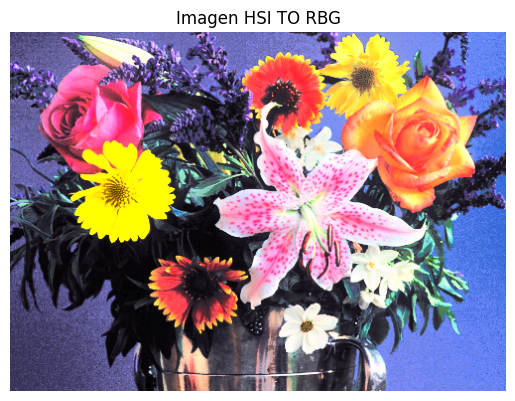

In [18]:
show_image(img_2, "Imagen HSI TO RBG")